In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### Link to dataset

https://www.kaggle.com/datasets/osmi/mental-health-in-tech-survey

In [2]:
#read in the cleaned dataset
mhtech = pd.read_csv('mhtech.csv')
mhtech.head()

,Age,Gender,Country,family_history,treatment,work_interfere,no_employees,remote_work,benefits,care_options,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,No,Yes,Often,6-25,No,Yes,Not sure,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,32,Male,Canada,No,No,Rarely,6-25,No,No,No,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
2,31,Male,United Kingdom,Yes,Yes,Often,26-100,No,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
3,31,Male,United States,No,No,Never,100-500,Yes,Yes,No,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
4,33,Male,United States,Yes,No,Sometimes,6-25,No,Yes,Not sure,...,Don't know,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No


In [4]:
mhtech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        833 non-null    int64 
 1   Gender                     833 non-null    object
 2   Country                    833 non-null    object
 3   family_history             833 non-null    object
 4   treatment                  833 non-null    object
 5   work_interfere             833 non-null    object
 6   no_employees               833 non-null    object
 7   remote_work                833 non-null    object
 8   benefits                   833 non-null    object
 9   care_options               833 non-null    object
 10  wellness_program           833 non-null    object
 11  seek_help                  833 non-null    object
 12  anonymity                  833 non-null    object
 13  leave                      833 non-null    object
 14  mental_hea

### EDA


C:\Users\amass\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


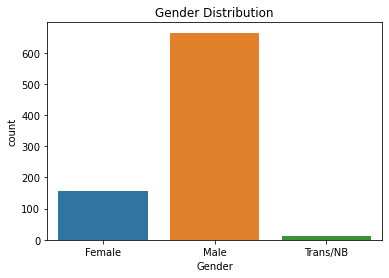

In [5]:
#visualize gender distribution
sns.countplot(mhtech['Gender']).set_title('Gender Distribution');

In [ ]:
#There are far more males in the dataset than females or trans/non-binary individuals. 
#This seems to reflect the gender distribution in tech in 2014. 

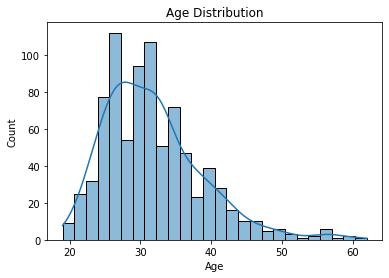

In [6]:
#visualize age distribution
sns.histplot(data=mhtech, x='Age', kde=True).set_title('Age Distribution')
plt.show()

In [ ]:
#The age distribution seems normal given the data. Most tech workers who responded to the survey were between 25 and 35.

In [7]:
#visualize distribution of some categorical/binary variables
val_cnt = mhtech.drop(['Age', 'Gender', 'Country', 'work_interfere', 'no_employees', 'care_options', 'leave', ], axis = 1)
val_cnt.apply(pd.value_counts).T
#this table is very hard to read

,Don't know,Maybe,No,Some of them,Yes
family_history,NaN,NaN,518.0,NaN,315.0
treatment,NaN,NaN,423.0,NaN,410.0
remote_work,NaN,NaN,620.0,NaN,213.0
benefits,289.0,NaN,198.0,NaN,346.0
wellness_program,136.0,NaN,560.0,NaN,137.0
seek_help,263.0,NaN,412.0,NaN,158.0
anonymity,574.0,NaN,31.0,NaN,228.0
mental_health_consequence,NaN,314.0,336.0,NaN,183.0
phys_health_consequence,NaN,163.0,632.0,NaN,38.0
coworkers,NaN,NaN,171.0,516.0,146.0


In [8]:
#separate by values
yn_cnt = mhtech[['family_history', 'treatment', 'remote_work', 'obs_consequence']]
ynm_cnt = mhtech[['mental_health_consequence', 'phys_health_consequence', 'mental_health_interview', 'phys_health_interview']]
yndk_cnt = mhtech[['benefits', 'wellness_program', 'seek_help', 'anonymity', 'mental_vs_physical']]
ynsot_cnt = mhtech[['coworkers', 'supervisor']]

In [9]:
yn_cnt.apply(pd.value_counts).T

,No,Yes
family_history,518,315
treatment,423,410
remote_work,620,213
obs_consequence,728,105


In [10]:
#The target variable (treatment) is evenly distributed
#Not many employees have observed consequences for speaking about mental health.

In [11]:
ynm_cnt.apply(pd.value_counts).T

,Maybe,No,Yes
mental_health_consequence,314,336,183
phys_health_consequence,163,632,38
mental_health_interview,141,665,27
phys_health_interview,369,336,128


In [12]:
#Not many employees are confident that there would be consequences for discussing mental or physical health issues with employers
#Most employees would not be comfortable discussing mental health in an interview
#Though not many employees would discuss physical health issues in an interview, more are likely to consider it than mental health

In [13]:
yndk_cnt.apply(pd.value_counts).T

,Don't know,No,Yes
benefits,289,198,346
wellness_program,136,560,137
seek_help,263,412,158
anonymity,574,31,228
mental_vs_physical,405,213,215


In [14]:
#Many employees are unaware of the mental health resources available to them and their protections in using them

In [15]:
ynsot_cnt.apply(pd.value_counts).T

,No,Some of them,Yes
coworkers,171,516,146
supervisor,257,237,339


In [16]:
#Most employees feel that their comfort level speaking to coworkers about mental health depends on the individual. 

C:\Users\amass\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


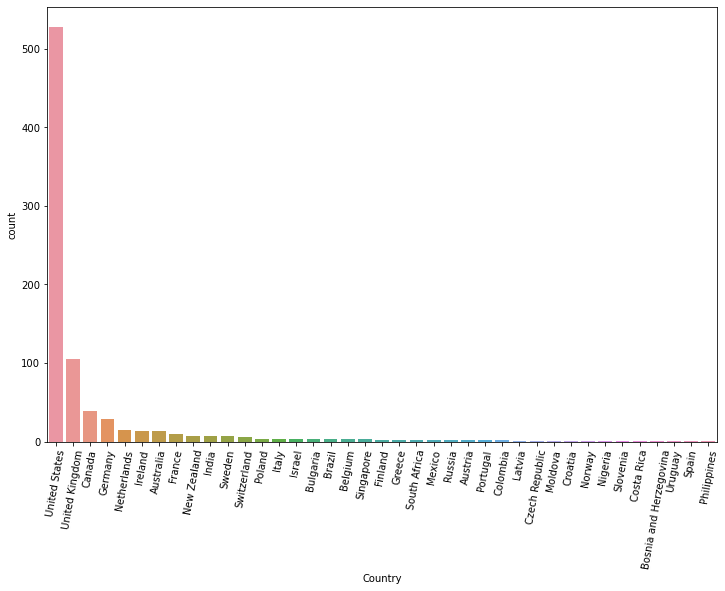

In [17]:
#visualize country distribution
plt.figure(figsize=(12, 8));
sns.countplot(mhtech['Country'], order=mhtech['Country'].value_counts().index);
plt.xticks(rotation=80);

In [18]:
#United States makes up the majority of countries in the survey

C:\Users\amass\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


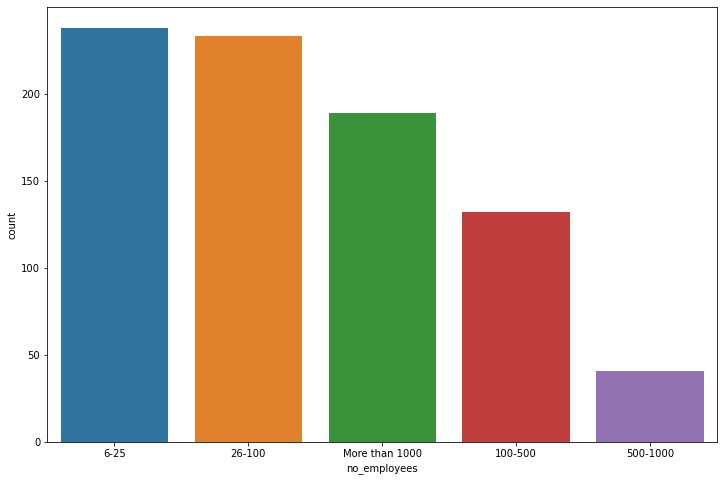

In [19]:
#visualize number of employees distribution
plt.figure(figsize=(12, 8));
sns.countplot(mhtech['no_employees'], order=mhtech['no_employees'].value_counts().index);

In [20]:
mhtech['no_employees'].value_counts()

6-25              238
26-100            233
More than 1000    189
100-500           132
500-1000           41
Name: no_employees, dtype: int64

In [21]:
#Most employees work at companies with between 6 and 100 employees. 

### Visualizations

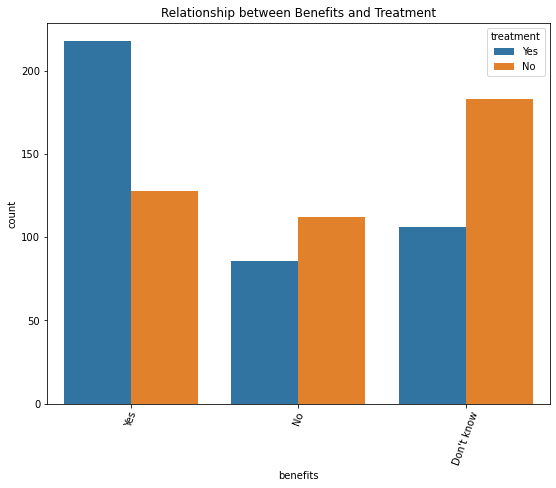

In [22]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'benefits', hue='treatment').set_title('Relationship between Benefits and Treatment');
plt.xticks(rotation=70);

In [23]:
# Employees who know they have mental health care benefits may
#seek care more often than those who dont have benefits or are unaware of them

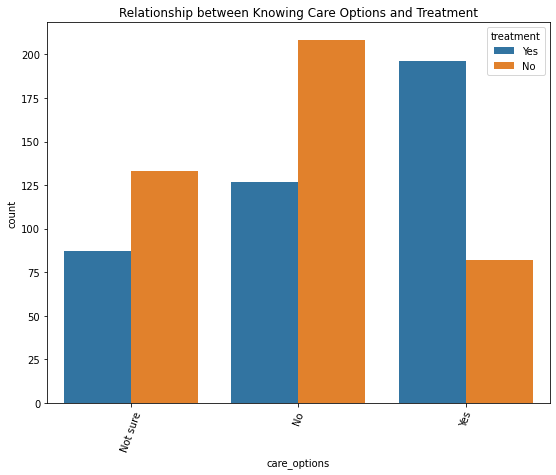

In [24]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'care_options', hue='treatment').set_title('Relationship between Knowing Care Options and Treatment');
plt.xticks(rotation=70);

In [25]:
# Employees who are aware of the mental health care options provided by their employer may be more likely
# to seek treatment than those who are unaware of the options provided. 

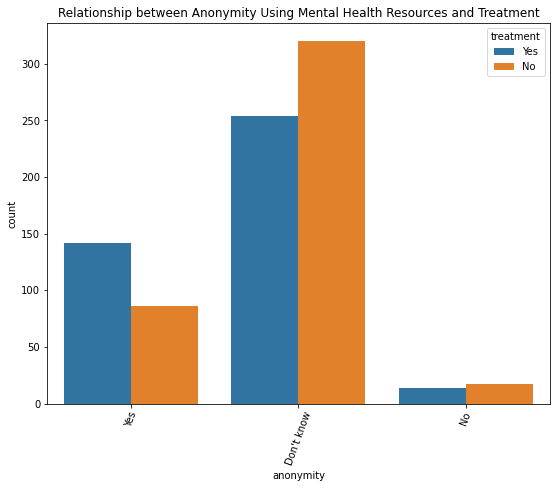

In [26]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'anonymity', hue='treatment').set_title('Relationship between Anonymity Using Mental Health Resources and Treatment');
plt.xticks(rotation=70);

In [27]:
# Employees who know they are protected under anonymity when taking advantage of mental health or substance abuse resources may 
# be more likely to seek treatment than those who dont know or who know they are not protected. 

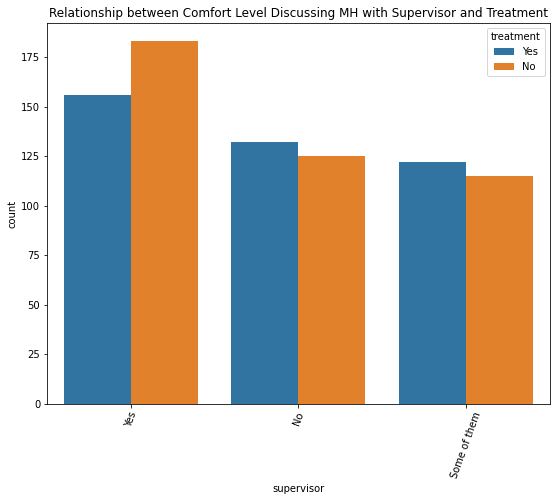

In [41]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'supervisor', hue='treatment').set_title('Relationship between Comfort Level Discussing MH with Supervisor and Treatment');
plt.xticks(rotation=70);

In [29]:
#Feeling comfortable speaking to a supervisor about mental health does not seem to increase an employees likelyhood to seek
# treatment.

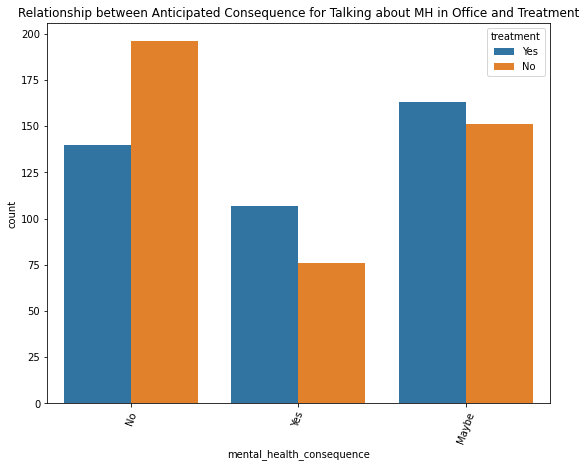

In [42]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'mental_health_consequence', hue='treatment').set_title('Relationship between Anticipated Consequence for Talking about MH in Office and Treatment');
plt.xticks(rotation=70);

In [31]:
#interestingly, employees who think that discussing a mental health issue with their employer would have negative consequences
# are still likely to seek treatment. 

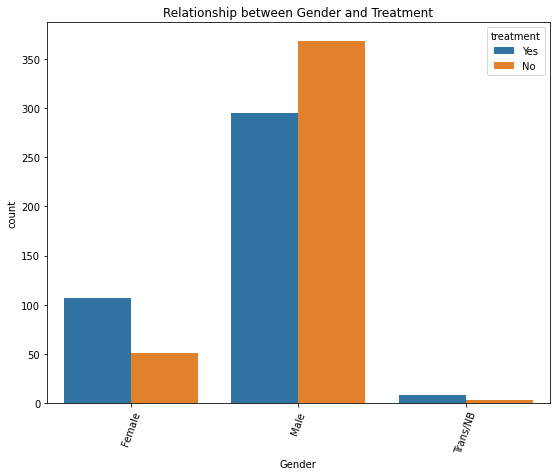

In [43]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'Gender', hue='treatment').set_title('Relationship between Gender and Treatment');
plt.xticks(rotation=70);

In [33]:
#females and trans/nb individuls are more likely to seek treatment for mental health conditions than males
#this is already a fairly well known fact in the health care industry.

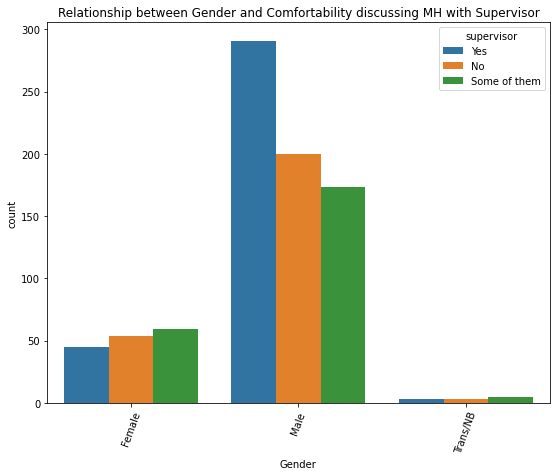

In [46]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'Gender', hue='supervisor').set_title('Relationship between Gender and Comfortability discussing MH with Supervisor');
plt.xticks(rotation=70);

In [ ]:
#males are more likely to feel comfortable speaking to supervisors about mental health concerns

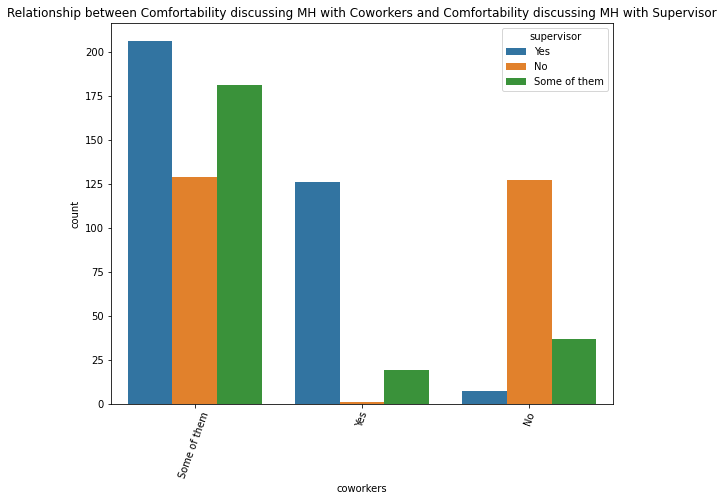

In [47]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'coworkers', hue='supervisor').set_title('Relationship between Comfortability discussing MH with Coworkers and Comfortability discussing MH with Supervisor');
plt.xticks(rotation=70);

In [ ]:
#comfortability talking to coworkers about mental health is a good indicator of whether an employee will talk to a supervisor 
#about mental health

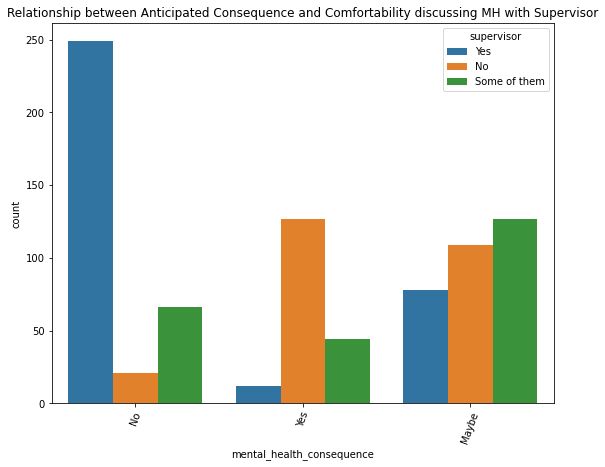

In [48]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'mental_health_consequence', hue='supervisor').set_title('Relationship between Anticipated Consequence and Comfortability discussing MH with Supervisor');
plt.xticks(rotation=70);

In [ ]:
#Employees who do not think there would be consequences for discussing mental health
#in the workplace are much more likely to talk to a supervisor about mental health.
#Those who do anticipate consequences are much less likely to talk to a supervisor.
#Those who are unsure would only be willing to talk to some supervisors about mental health
#most likely those they trust or have a good relationship with.

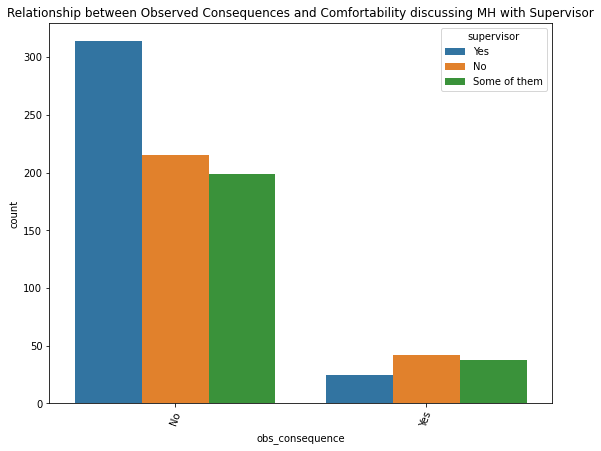

In [49]:
plt.figure(figsize=(9,7));
sns.countplot(data = mhtech, x = 'obs_consequence', hue='supervisor').set_title('Relationship between Observed Consequences and Comfortability discussing MH with Supervisor');
plt.xticks(rotation=70);

In [ ]:
#Employees who have observed negative conseqences for speaking about mental health
#in the workplace are not likely to talk to a supervisor about mental health,
#especially compared to those who have not observed negative consequences.

### Data Preparation

In [3]:
#one hot encode (replace yes/no only columns with 1s and 0s before encoding the rest of the categorical values)

#map 1s and 0s to binary columns
mhtech.family_history = mhtech.family_history.map(dict(Yes=1, No=0))
mhtech.treatment = mhtech.treatment.map(dict(Yes=1, No=0))
mhtech.remote_work = mhtech.remote_work.map(dict(Yes=1, No=0))
mhtech.obs_consequence = mhtech.obs_consequence.map(dict(Yes=1, No=0))

#scale age variable
scaler=StandardScaler()
mhtech.Age=scaler.fit_transform(mhtech[['Age']])

#use one hot encoding for the rest of the categorical columns
mhtech_encoded = pd.get_dummies(mhtech)


In [4]:
pd.set_option('display.max_columns', None)
mhtech_encoded.head()

,Age,family_history,treatment,remote_work,obs_consequence,Gender_Female,Gender_Male,Gender_Trans/NB,Country_Australia,Country_Austria,Country_Belgium,Country_Bosnia and Herzegovina,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Colombia,Country_Costa Rica,Country_Croatia,Country_Czech Republic,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_India,Country_Ireland,Country_Israel,Country_Italy,Country_Latvia,Country_Mexico,Country_Moldova,Country_Netherlands,Country_New Zealand,Country_Nigeria,Country_Norway,Country_Philippines,Country_Poland,Country_Portugal,Country_Russia,Country_Singapore,Country_Slovenia,Country_South Africa,Country_Spain,Country_Sweden,Country_Switzerland,Country_United Kingdom,Country_United States,Country_Uruguay,work_interfere_Never,work_interfere_NotApplicable,work_interfere_Often,work_interfere_Rarely,work_interfere_Sometimes,no_employees_100-500,no_employees_26-100,no_employees_500-1000,no_employees_6-25,no_employees_More than 1000,benefits_Don't know,benefits_No,benefits_Yes,care_options_No,care_options_Not sure,care_options_Yes,wellness_program_Don't know,wellness_program_No,wellness_program_Yes,seek_help_Don't know,seek_help_No,seek_help_Yes,anonymity_Don't know,anonymity_No,anonymity_Yes,leave_Don't know,leave_Somewhat difficult,leave_Somewhat easy,leave_Very difficult,leave_Very easy,mental_health_consequence_Maybe,mental_health_consequence_No,mental_health_consequence_Yes,phys_health_consequence_Maybe,phys_health_consequence_No,phys_health_consequence_Yes,coworkers_No,coworkers_Some of them,coworkers_Yes,supervisor_No,supervisor_Some of them,supervisor_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes
0,0.749949,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1
1,0.035834,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0
2,-0.106989,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0
3,-0.106989,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0
4,0.178657,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0


In [5]:
mhtech_encoded.info()
#we have 98 columns and 96 possible predictor variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 98 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              833 non-null    float64
 1   family_history                   833 non-null    int64  
 2   treatment                        833 non-null    int64  
 3   remote_work                      833 non-null    int64  
 4   obs_consequence                  833 non-null    int64  
 5   Gender_Female                    833 non-null    uint8  
 6   Gender_Male                      833 non-null    uint8  
 7   Gender_Trans/NB                  833 non-null    uint8  
 8   Country_Australia                833 non-null    uint8  
 9   Country_Austria                  833 non-null    uint8  
 10  Country_Belgium                  833 non-null    uint8  
 11  Country_Bosnia and Herzegovina   833 non-null    uint8  
 12  Country_Brazil        

### Explore factors influencing whether or not an individual seeks treatment for mental health.

In [6]:
#define X and y values
y = mhtech_encoded['treatment']
X = mhtech_encoded.drop('treatment', axis = 1)


In [7]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(666, 97) (666,) (167, 97) (167,)


In [8]:
#Build Random Forest model and fit with training data
RF = RandomForestClassifier(random_state = 0)
RF.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

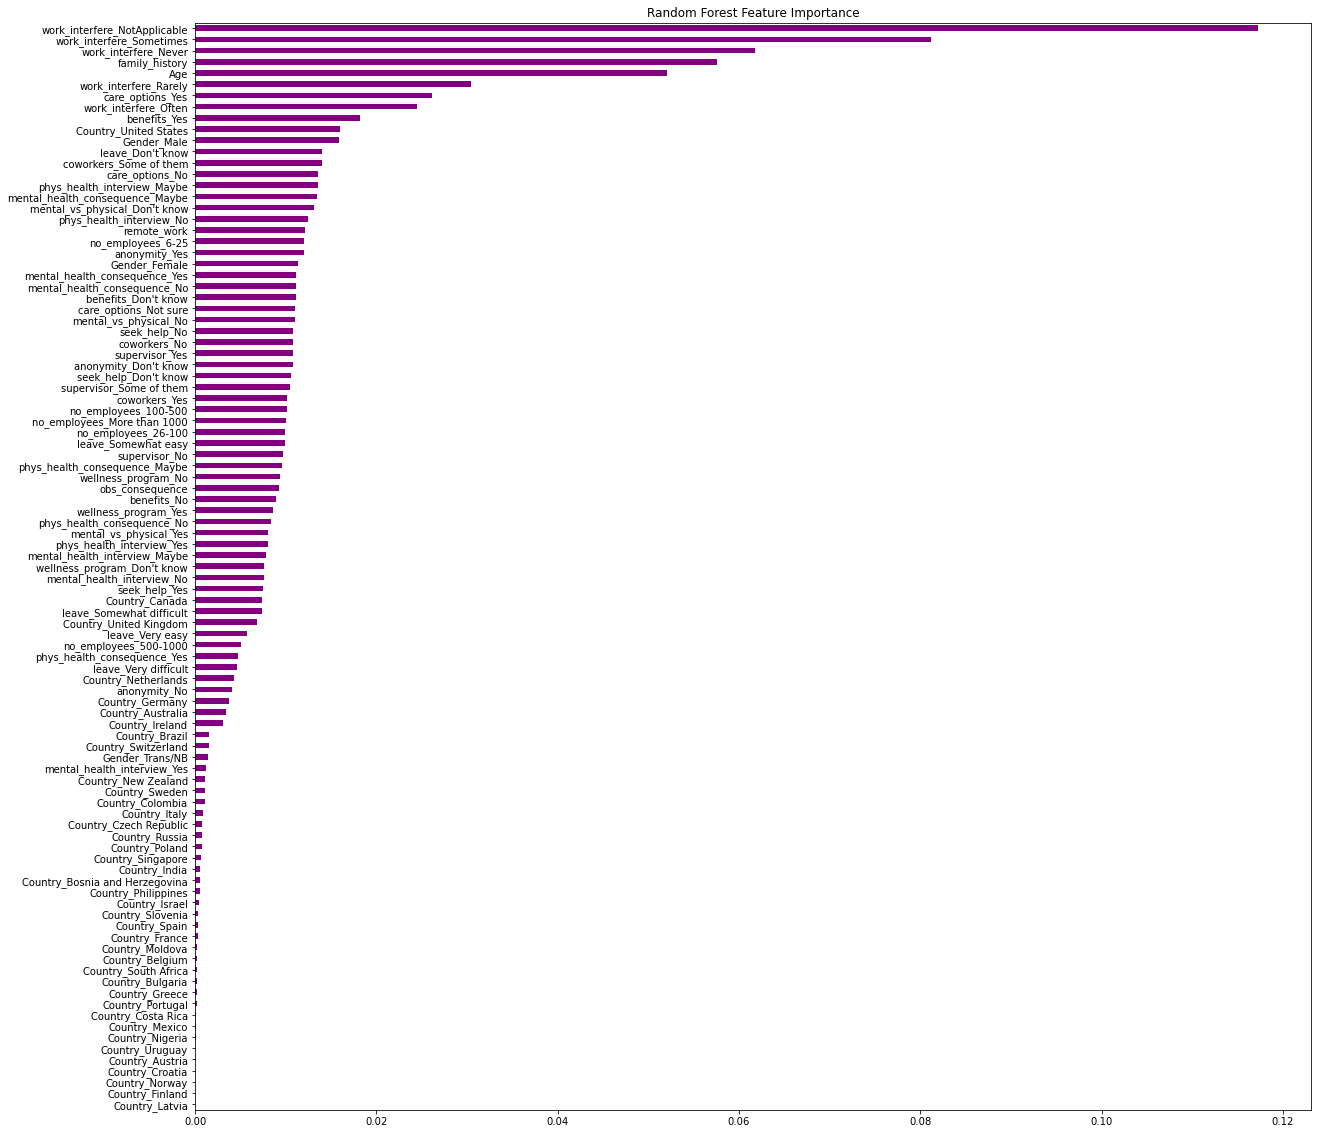

In [9]:
#get feature importances from random forest and plot them 
imp = RF.feature_importances_
series_imp = pd.Series(imp, index=X_train.columns)
series_imp.sort_values(ascending=True, inplace=True)


series_imp.plot.barh(color = 'purple',figsize = (20, 20), title = 'Random Forest Feature Importance', fontsize = 10);

In [10]:
#re-define X and y values (dropping low importance features 
#AND dropping work_interfere_NotApplicable as it most likely indicates individuals who do not have mental health conditions)

y = mhtech_encoded['treatment']
X = mhtech_encoded.drop(['treatment', 
                         'Country_Latvia', 'Country_Finland', 'Country_Norway', 'Country_Croatia', 
                         'Country_Austria', 'Country_Uruguay', 'Country_Nigeria', 'Country_Mexico', 'Country_Costa Rica',
                         'Country_Portugal', 'Country_Greece', 'Country_Bulgaria', 'Country_South Africa', 'Country_Belgium',
                         'Country_Moldova', 'Country_France', 'Country_Spain', 'Country_Slovenia', 'Country_Israel', 
                         'Country_Philippines', 'Country_Bosnia and Herzegovina', 'Country_India', 'Country_Singapore',
                         'Country_Poland', 'Country_Russia', 'Country_Czech Republic', 'Country_Italy', 'Country_Colombia',
                         'Country_Sweden', 'Country_New Zealand', 'Country_Switzerland', 'Country_Brazil',
                         'mental_health_interview_Yes', 'Gender_Trans/NB', 'work_interfere_NotApplicable']
                        , axis = 1)

In [11]:
#re-split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(666, 62) (666,) (167, 62) (167,)


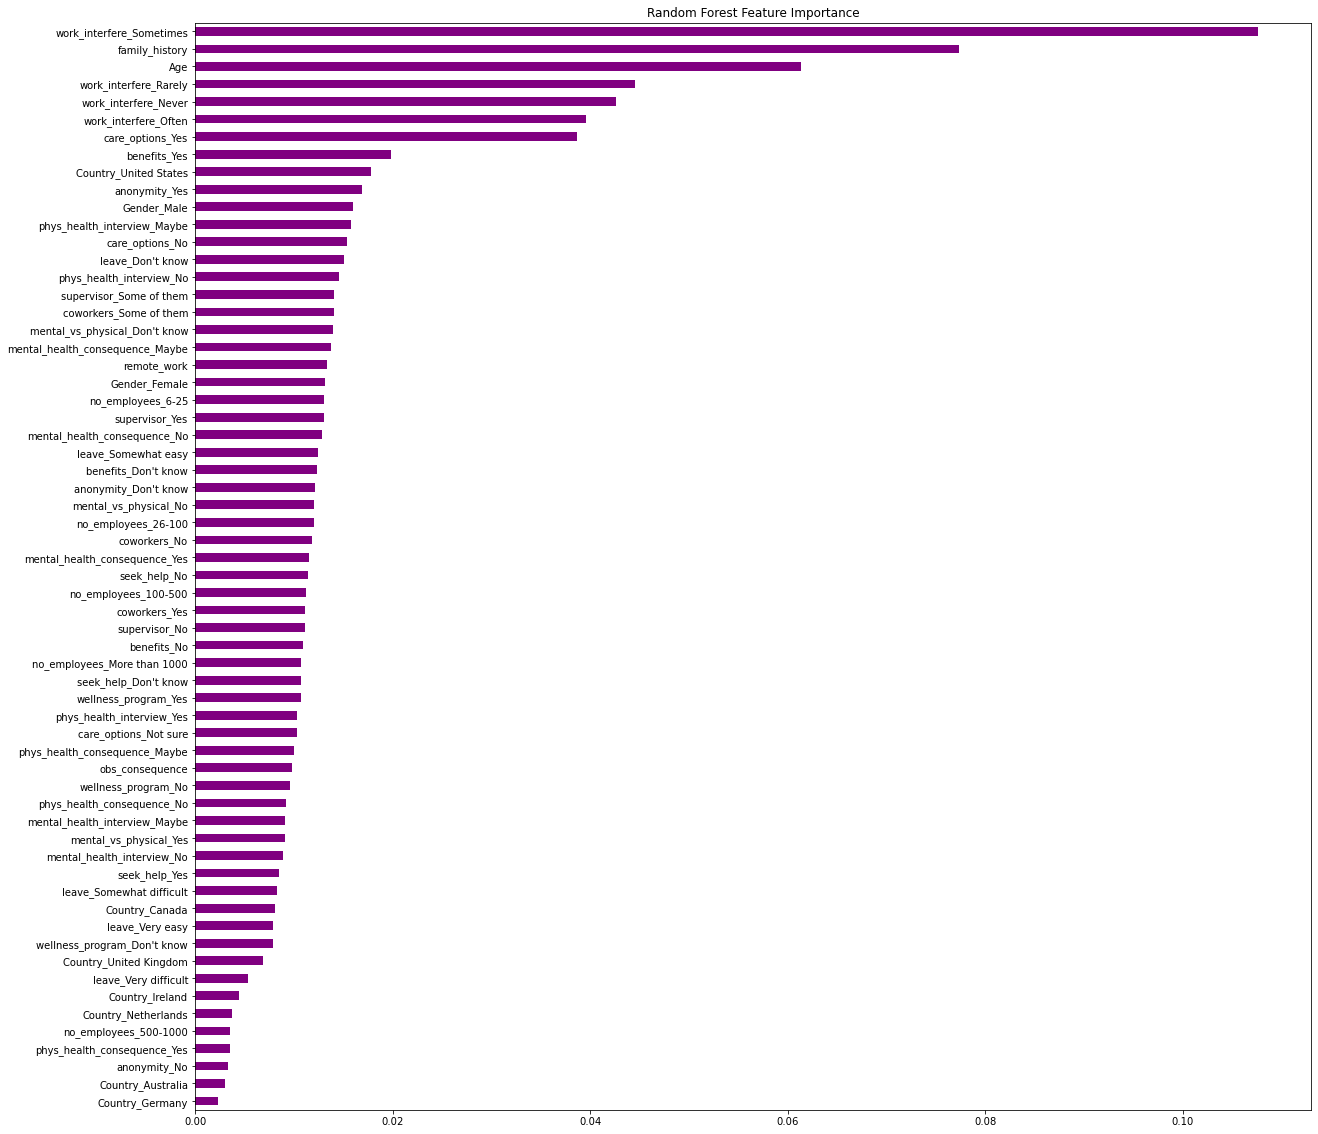

In [13]:
#re fit random forest to see how dropped variables affect feature importance
RF = RandomForestClassifier(random_state = 0)
RF.fit(X_train, y_train)

imp = RF.feature_importances_
series_imp = pd.Series(imp, index=X_train.columns)
series_imp.sort_values(ascending=True, inplace=True)


series_imp.plot.barh(color = 'purple',figsize = (20, 20), title = 'Random Forest Feature Importance', fontsize = 10);

In [ ]:
# Important features for predicting treatment found by RF include: 
# Whether or not mental health affects work
# Family history of mental illness
# Age
# Knowing mental health care options provided by employers
# Employer provided mental health care benefits
# Living in the United States
# Anonymity in seeking help
# Gender

In [ ]:
#Now I want to compare the feature importance from Random Forest to an XGBoost classifier

In [14]:
#xgboost classifier
XG = xgb.XGBClassifier()
XG.fit(X_train, y_train)
XG_train_pred = XG.predict(X_train)
XG_test_pred = XG.predict(X_test)

In [15]:
XG_train_accuracy = accuracy_score(y_train, XG_train_pred)
XG_test_accuracy = accuracy_score(y_test, XG_test_pred)
print('XGBoost Training Accuracy: ', XG_train_accuracy)
print('XGBoost Testing Accuracy: ', XG_test_accuracy)

XGBoost Training Accuracy:  1.0
XGBoost Testing Accuracy:  0.7664670658682635


In [16]:
#the base xgboostclassifier model is quite overfit

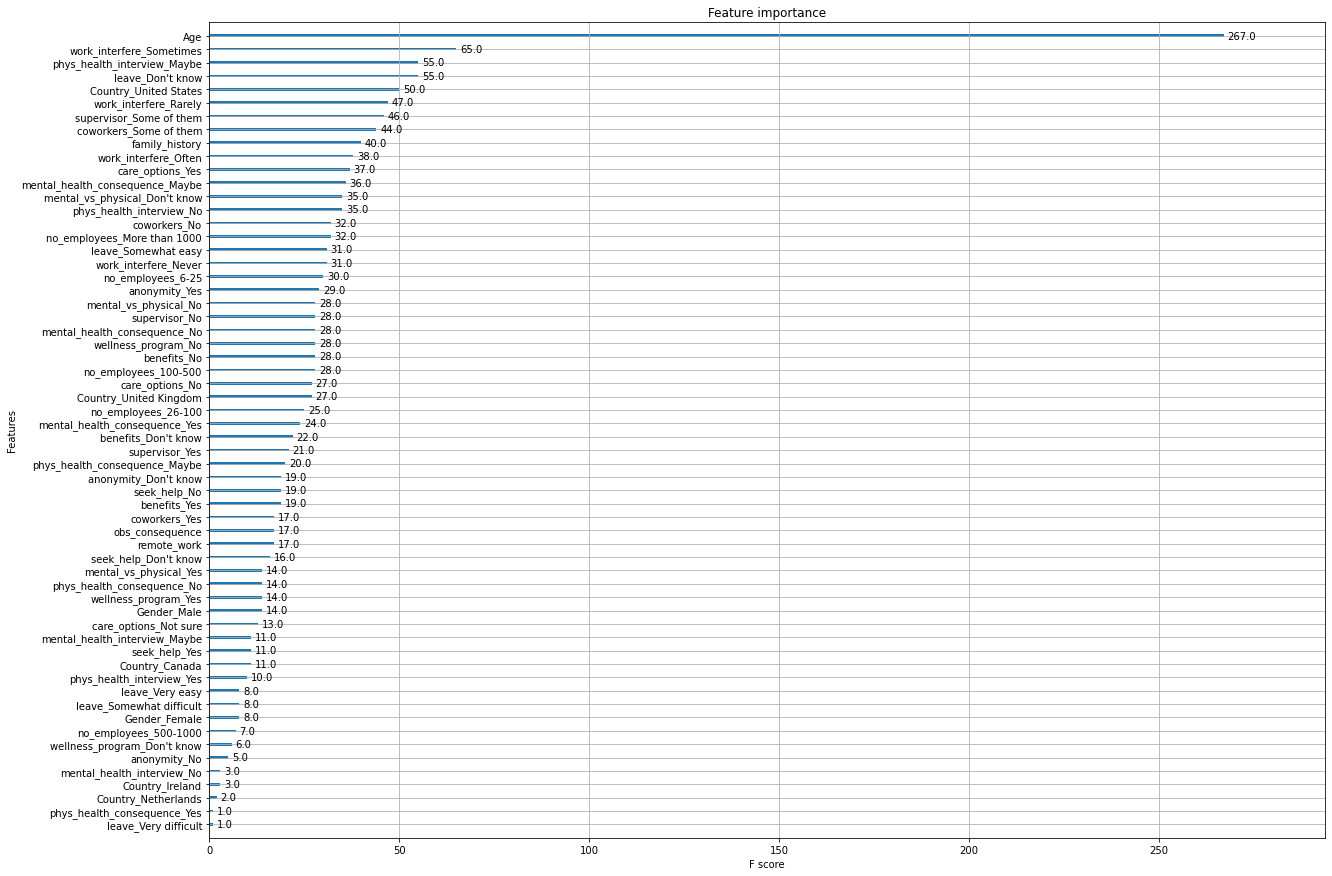

In [17]:
plt.figure(figsize=(20,15))
xgb.plot_importance(XG, ax=plt.gca());

In [36]:
#Tune model using gridsearch cv (commented out to avoid long run times if the whole notebook is run at once)

#param_grid = {"learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
             #"min_split_loss" : range(0, 8),
             #"max_depth" : range(3, 9),
             #"min_child_weight" : range(1, 8),
             # "random_state" : [0]
            # }

#XG = xgb.XGBClassifier()
#gs_XG = GridSearchCV(XG, param_grid)
#gs_XG.fit(X_train, y_train)

#print(gs_XG.best_estimator_.get_params())

In [37]:
#Create new model based on tuning
XG = xgb.XGBClassifier(learning_rate = 0.3,
                      min_split_loss = 5,
                      max_depth = 3,
                      min_child_weight = 1,
                      random_state=0)

XG.fit(X_train, y_train)
XG_train_pred = XG.predict(X_train)
XG_test_pred = XG.predict(X_test)

In [40]:
XG_train_accuracy = accuracy_score(y_train, XG_train_pred)
XG_test_accuracy = accuracy_score(y_test, XG_test_pred)
print('XGBoost Training Accuracy: ', XG_train_accuracy)
print('XGBoost Testing Accuracy: ', XG_test_accuracy)

XGBoost Training Accuracy:  0.8498498498498499
XGBoost Testing Accuracy:  0.7844311377245509


In [ ]:
#model is much less overfit and the test accuracy has improved

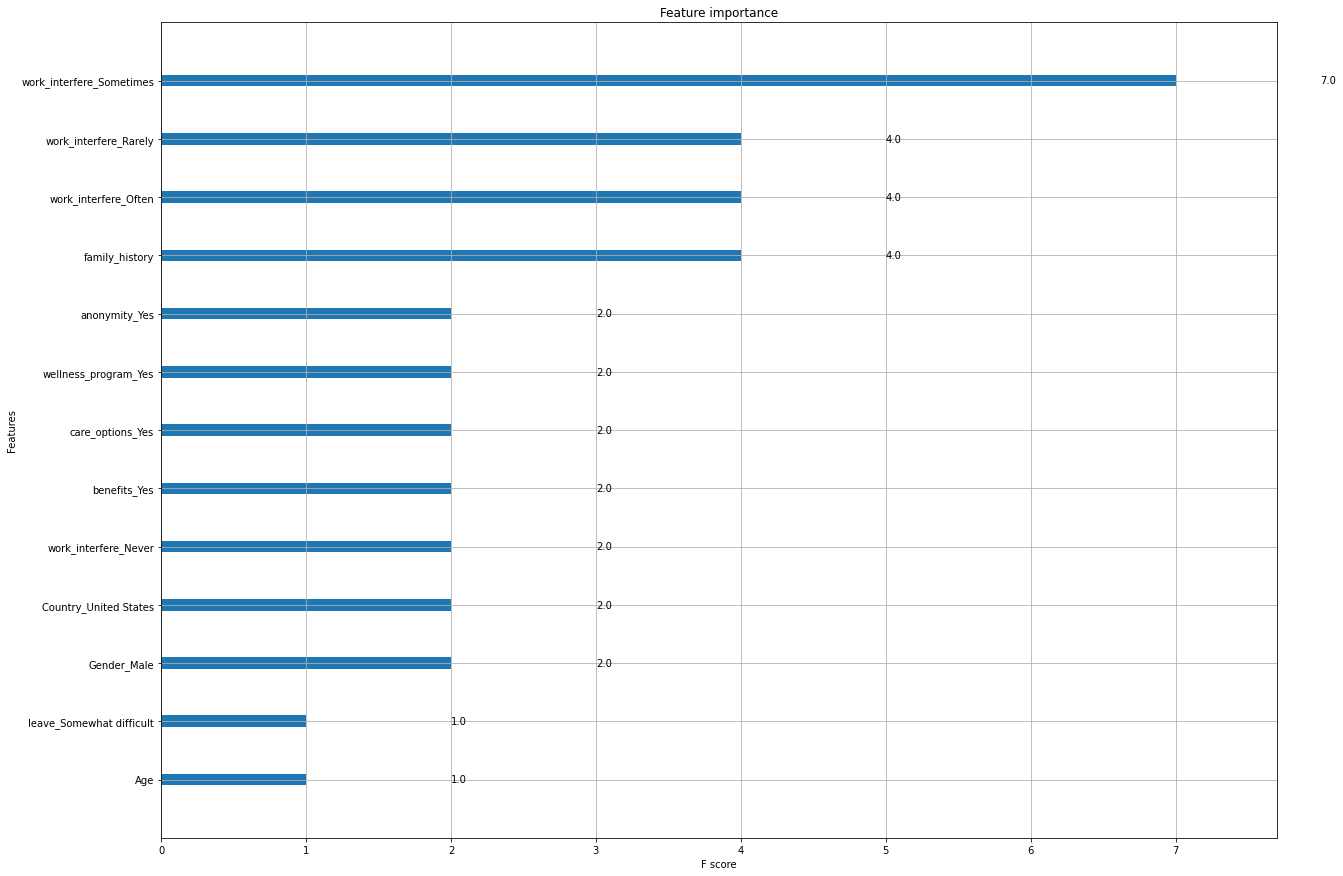

In [38]:
plt.figure(figsize=(20,15))
xgb.plot_importance(XG, ax=plt.gca());

In [39]:
# Important features for predicting treatment found by XGBoost include:

# Whether or not mental health affects work
# Family history of mental illness
# Anonymity in seeking help
# Employers discussing mental health as part of a wellness program
# Knowing mental health care options provided by employers
# Employer provided mental health care benefits
# Living in the United States
# Gender
# Level of difficulty taking medical leave for a mental health condition
# Age

In [ ]:
# Random Forest and XGboost had pretty similar feature importances 
# Though there were differences in the level of importance of some features

### Explore factors influencing likelyhood to talk about mental health with supervisors

In [32]:
#Re-encode so that supervisor column is predictable

#use label encoder on supervisor column
le = LabelEncoder()
mhtech.supervisor = le.fit_transform(mhtech.supervisor)

#use one hot encoding for the rest of the categorical columns
mhtech_encoded2 = pd.get_dummies(mhtech)


In [33]:
#re-define X and y values again
y = mhtech_encoded2['supervisor']
X = mhtech_encoded2.drop('supervisor', axis = 1)


In [34]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(666, 95) (666,) (167, 95) (167,)


In [35]:
#Build Random Forest model and fit with training data
RF = RandomForestClassifier(random_state = 0)
RF.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

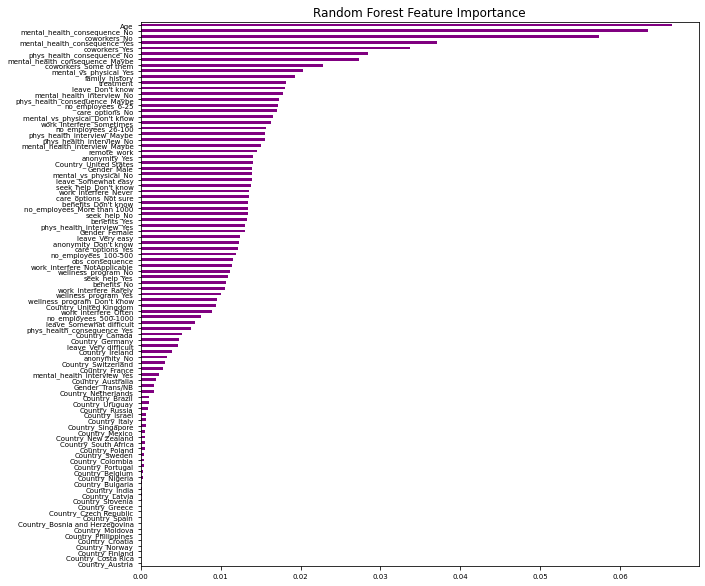

In [36]:
#get feature importances from random forest and plot them and plot them 
imp = RF.feature_importances_
series_imp = pd.Series(imp, index=X_train.columns)
series_imp.sort_values(ascending=True, inplace=True)


series_imp.plot.barh(color = 'purple',figsize = (10, 10), title = 'Random Forest Feature Importance', fontsize = 7);

In [37]:
#re-define X and y values (dropping low importance features)
y = mhtech_encoded2['supervisor']
X = mhtech_encoded2.drop(['supervisor', 
                         'Country_Latvia', 'Country_Finland', 'Country_Norway', 'Country_Croatia', 
                         'Country_Austria', 'Country_Uruguay', 'Country_Nigeria', 'Country_Mexico', 'Country_Costa Rica',
                         'Country_Portugal', 'Country_Greece', 'Country_Bulgaria', 'Country_South Africa', 'Country_Belgium',
                         'Country_Moldova', 'Country_France', 'Country_Spain', 'Country_Slovenia', 'Country_Israel', 
                         'Country_Philippines', 'Country_Bosnia and Herzegovina', 'Country_India', 'Country_Singapore',
                         'Country_Poland', 'Country_Russia', 'Country_Czech Republic', 'Country_Italy', 'Country_Colombia',
                         'Country_Sweden', 'Country_New Zealand', 'Country_Switzerland', 'Country_Brazil',
                         'Country_Netherlands']
                        , axis = 1)

In [38]:
#re-split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(666, 62) (666,) (167, 62) (167,)


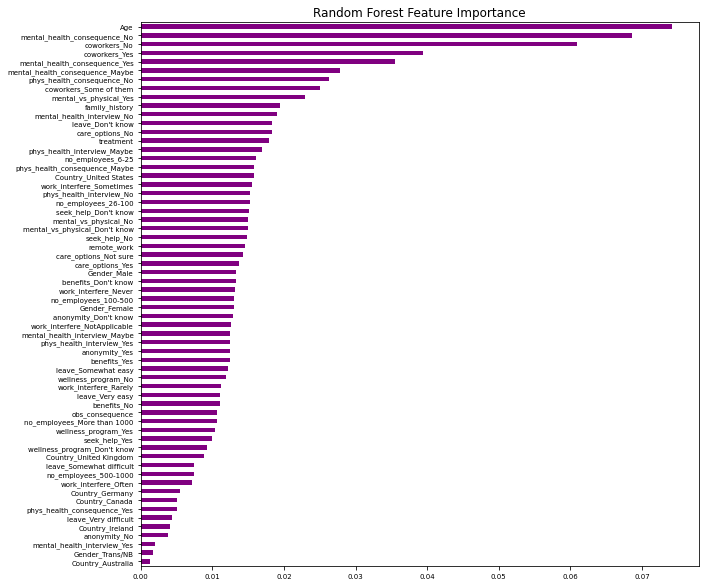

In [39]:
#re fit random forest to see how dropped variables affect feature importance

RF = RandomForestClassifier(random_state = 0)
RF.fit(X_train, y_train)

imp = RF.feature_importances_
series_imp = pd.Series(imp, index=X_train.columns)
series_imp.sort_values(ascending=True, inplace=True)


series_imp.plot.barh(color = 'purple',figsize = (10, 10), title = 'Random Forest Feature Importance', fontsize = 7);

In [40]:
# Important features for predicting likelyhood to speak to supervisor about mental health issues found by RF include: 
# Age
# Whether the individual anticipates negative consequences for speaking about mental health issues with employer
# Willingness to speak with coworkers about mental health issues
# Whether the individual anticipates negative consequences for speaking about physical health issues with employer
# Whether or not the individual feels their employer takes mental health as seriously as physical health 
# Family history of mental illness
# Willingness to bring up mental health in an interview with a potential employer
# Level of difficulty taking medical leave for a mental health condition
# Knowing the options for mental health care provided by employer
# Whether or not the individual has sought out treatment for a mental health condition

# Interestingly mental health interfering with work is not as high on the feature importance as I expected

In [41]:
#Now compare xgboost classifier

In [42]:
#xgboost classifier
XG = xgb.XGBClassifier()
XG.fit(X_train, y_train)
XG_train_pred = XG.predict(X_train)
XG_test_pred = XG.predict(X_test)

In [43]:
XG_train_accuracy = accuracy_score(y_train, XG_train_pred)
XG_test_accuracy = accuracy_score(y_test, XG_test_pred)
print('XGBoost Training Accuracy: ', XG_train_accuracy)
print('XGBoost Testing Accuracy: ', XG_test_accuracy)

XGBoost Training Accuracy:  1.0
XGBoost Testing Accuracy:  0.592814371257485


In [44]:
#once again the model is overfit, the test accuracy is also quite low

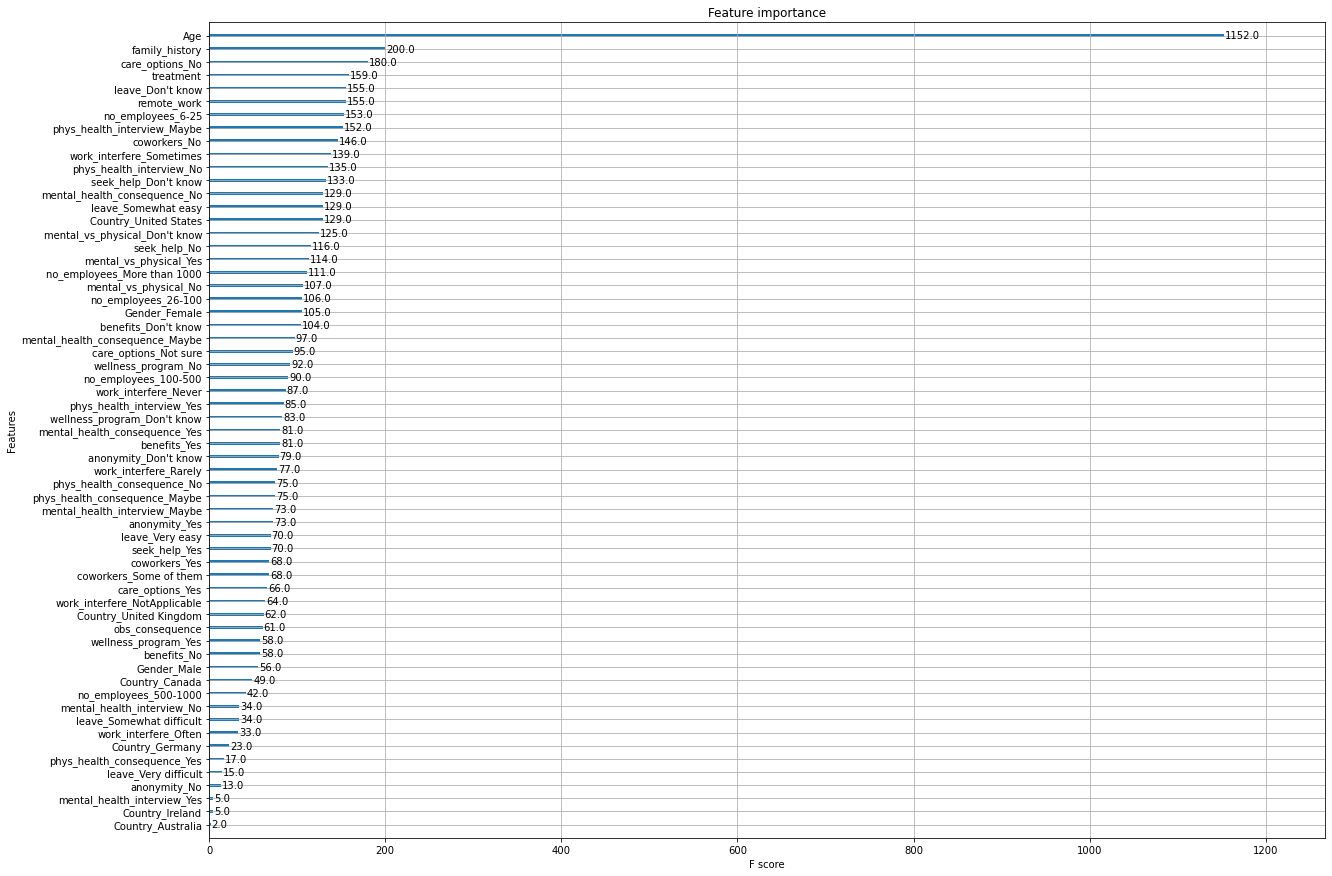

In [45]:
plt.figure(figsize=(20,15))
xgb.plot_importance(XG, ax=plt.gca());

In [46]:
#Tune model using gridsearch cv (commented out to avoid long run times if the whole notebook is run at once)

#param_grid = {"learning_rate" : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
             #"min_split_loss" : range(0, 8),
             #"max_depth" : range(3, 9),
             #"min_child_weight" : range(1, 8),
             # "subsample" : [0.0, 0.2, 0.4, 0.6, 0.8, 1],
             #"random_state" : [0]
            # }

#XG = xgb.XGBClassifier()
#gs_XG = GridSearchCV(XG, param_grid)
#gs_XG.fit(X_train, y_train)

#print(gs_XG.best_estimator_.get_params())

In [47]:
#Create new model based on tuning
XG = xgb.XGBClassifier(learning_rate = 0.2,
                      min_split_loss = 1,
                      max_depth = 4,
                      min_child_weight = 2,
                      subsample = 1, 
                      random_state=0)

XG.fit(X_train, y_train)
XG_train_pred = XG.predict(X_train)
XG_test_pred = XG.predict(X_test)

In [48]:
XG_train_accuracy = accuracy_score(y_train, XG_train_pred)
XG_test_accuracy = accuracy_score(y_test, XG_test_pred)
print('XGBoost Training Accuracy: ', XG_train_accuracy)
print('XGBoost Testing Accuracy: ', XG_test_accuracy)

XGBoost Training Accuracy:  0.7897897897897898
XGBoost Testing Accuracy:  0.592814371257485


In [49]:
#tuning the model did reduce overfitting but the overall accuracy is still quite low

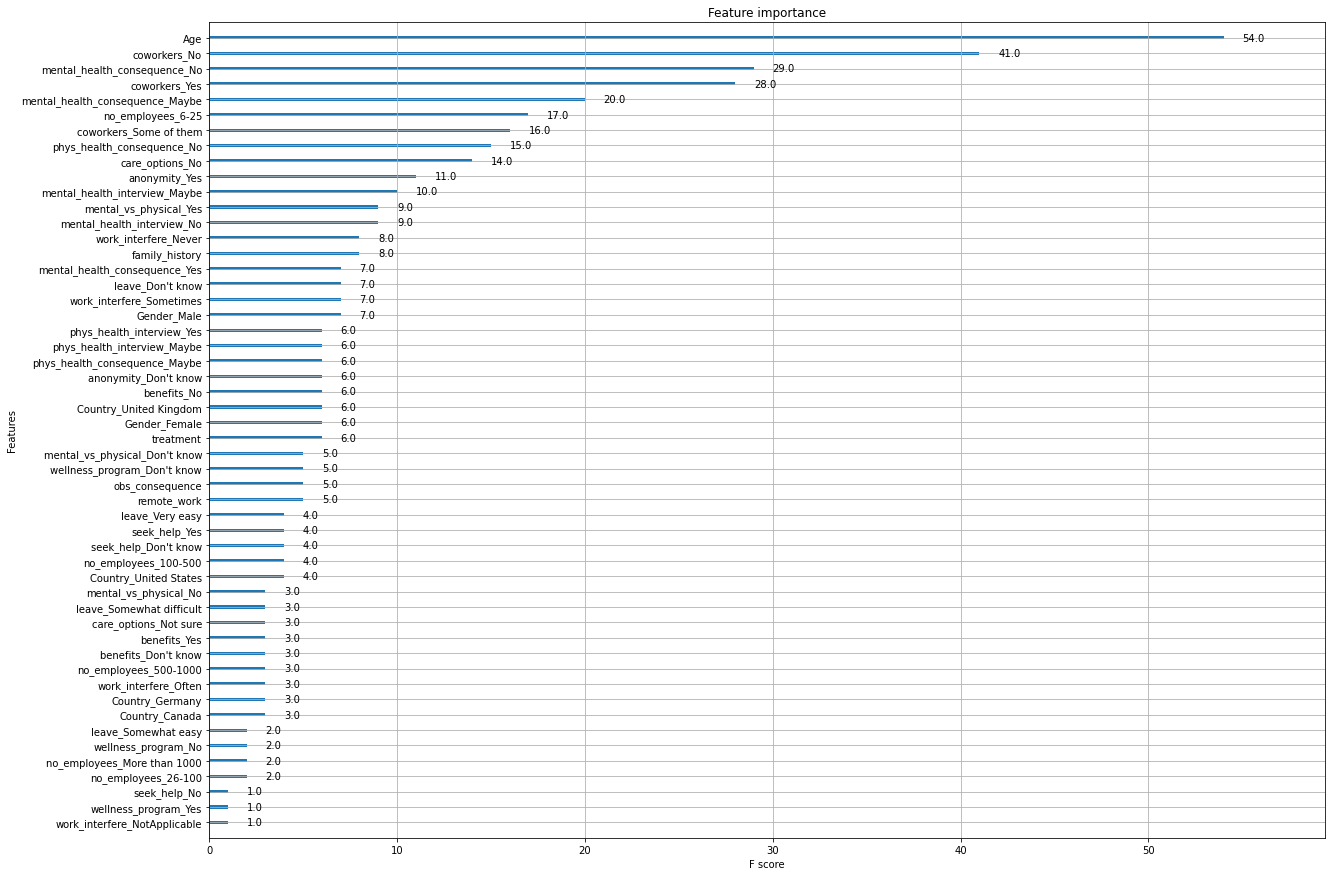

In [50]:
plt.figure(figsize=(20,15))
xgb.plot_importance(XG, ax=plt.gca());

In [ ]:
# Important features for predicting likelyhood to speak to supervisor about mental health issues found by XGBoost include: 
# Age
# Willingness to speak with coworkers about mental health issues
# Whether the individual anticipates negative consequences for speaking about mental health issues with employer
# Number of employees 
# Whether the individual anticipates negative consequences for speaking about physical health issues with employer
# Knowing the options for mental health care provided by employer
# Anonymity in seeking help
# Willingness to bring up mental health in an interview with a potential employer


In [ ]:
# Once again Random Forest and XGboost had pretty similar feature importances 